## Homework 5

In [65]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
import tensorflow_addons as tfa
import tensorflow as tf

### Generate data given by the Lorenz Equations

In [23]:
# Define the Lorenz system's derivative function
def lorenz_deriv(x_y_z, t0, sigma=10, beta=8/3, rho=28):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Generate data for a given rho value
def generate_data(rho, seed=123):
    dt = 0.01
    T = 8
    t = np.arange(0, T + dt, dt)

    np.random.seed(seed)
    x0 = -15 + 30 * np.random.random((100, 3))

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])

    nn_input = np.zeros((100 * (len(t) - 1), 3))
    nn_output = np.zeros_like(nn_input)

    for j in range(100):
        nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
        nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

    return nn_input, nn_output

### Feed Forward Neural Network (FFNN)

In [24]:
def build_ffnn(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(input_shape[0], activation='linear')) # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

def train_ffnn(model, inputs, targets, epochs=100):
    model.fit(inputs, targets, epochs=epochs, verbose=1)

### Long Short Term Memory Network (LSTM)

In [25]:
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(input_shape[1], activation='linear')) # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

def train_lstm(model, inputs, targets, epochs=100):
    model.fit(inputs, targets, epochs=epochs, verbose=1)

### Recurrent Neural Network (RNN)

In [36]:
def build_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=input_shape))
    model.add(Dense(input_shape[1], activation='linear')) # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

def train_rnn(model, inputs, targets, epochs=100):
    model.fit(inputs, targets, epochs=epochs, verbose=1)

### Echo State Network (ESN)

In [60]:
def create_esn(input_shape, units, connectivity=0.1, leaky=1, spectral_radius=0.9):
    inputs = tf.keras.Input(shape=input_shape)
    esn_outputs = tfa.layers.ESN(units, connectivity, leaky, spectral_radius)(inputs)
    output = tf.keras.layers.Dense(3)(esn_outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

def train_esn(X_train, y_train, X_test, y_test, input_shape, reservoir_size, epochs=50, batch_size=32):
    esn_model = create_esn(input_shape, reservoir_size)
    esn_history = esn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)
    return esn_model, esn_history

### Training FFNN

In [11]:
# Generate data for each rho value
inputs_10, targets_10 = generate_data(10)
inputs_28, targets_28 = generate_data(28)
inputs_40, targets_40 = generate_data(40)

# Concatenate the inputs and targets
inputs = np.concatenate([inputs_10, inputs_28, inputs_40])
targets = np.concatenate([targets_10, targets_28, targets_40])

# Build the model
ffnn = build_ffnn(inputs.shape[1:])

# Train the model
train_ffnn(ffnn, inputs, targets, epochs=25)

Epoch 1/25
7500/7500 [==============================] - 9s 1ms/step - loss: 0.6107
Epoch 2/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0424
Epoch 3/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0266
Epoch 4/25
7500/7500 [==============================] - 7s 987us/step - loss: 0.0217
Epoch 5/25
7500/7500 [==============================] - 7s 997us/step - loss: 0.0195
Epoch 6/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0177
Epoch 7/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0172
Epoch 8/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0160
Epoch 9/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0157
Epoch 10/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0149
Epoch 11/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0146
Epoch 12/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.01

### Training LSTM

In [33]:
# Generate data for each rho value
inputs_10, targets_10 = generate_data(10)
inputs_28, targets_28 = generate_data(28)
inputs_40, targets_40 = generate_data(40)

# Concatenate the inputs and targets
inputs = np.concatenate([inputs_10, inputs_28, inputs_40])
targets = np.concatenate([targets_10, targets_28, targets_40])

# Reshape inputs for LSTM [samples, time steps, features]
inputs = inputs.reshape((inputs.shape[0], 1, inputs.shape[1]))

# Build the model
lstm = build_lstm(inputs.shape[1:])

# Train the model
train_lstm(lstm, inputs, targets, epochs=25)

Epoch 1/25
7500/7500 [==============================] - 11s 1ms/step - loss: 2.2165
Epoch 2/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0178
Epoch 3/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0147
Epoch 4/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0136
Epoch 5/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0130
Epoch 6/25
7500/7500 [==============================] - 11s 1ms/step - loss: 0.0127
Epoch 7/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0126
Epoch 8/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0121
Epoch 9/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0119
Epoch 10/25
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0118
Epoch 11/25
7500/7500 [==============================] - 11s 1ms/step - loss: 0.0117
Epoch 12/25
7500/7500 [==============================] - 10s 1ms/step - lo

### Training RNN

In [39]:
# Generate data for each rho value
inputs_10, targets_10 = generate_data(10)
inputs_28, targets_28 = generate_data(28)
inputs_40, targets_40 = generate_data(40)

# Concatenate the inputs and targets
inputs = np.concatenate([inputs_10, inputs_28, inputs_40])
targets = np.concatenate([targets_10, targets_28, targets_40])

# Reshape inputs for RNN [samples, time steps, features]
inputs = inputs.reshape((inputs.shape[0], 1, inputs.shape[1]))

# Build the model
rnn = build_rnn(inputs.shape[1:])

# Train the model
train_rnn(rnn, inputs, targets, epochs=25)

Epoch 1/25
7500/7500 [==============================] - 9s 1ms/step - loss: 2.9024
Epoch 2/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0729
Epoch 3/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0483
Epoch 4/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0346
Epoch 5/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0275
Epoch 6/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0238
Epoch 7/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0210
Epoch 8/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0185
Epoch 9/25
7500/7500 [==============================] - 9s 1ms/step - loss: 0.0169
Epoch 10/25
7500/7500 [==============================] - 9s 1ms/step - loss: 0.0159
Epoch 11/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0151
Epoch 12/25
7500/7500 [==============================] - 8s 1ms/step - loss: 0.0145
E

### Training ESN

In [63]:
# Generate data for each rho value
inputs_10, targets_10 = generate_data(10)
inputs_28, targets_28 = generate_data(28)
inputs_40, targets_40 = generate_data(40)

# Concatenate the inputs and targets
inputs = np.concatenate([inputs_10, inputs_28, inputs_40])
targets = np.concatenate([targets_10, targets_28, targets_40])

# Reshape inputs for ESN [samples, time steps, features]
inputs = inputs.reshape((inputs.shape[0], 1, inputs.shape[1]))

# Split data into training and test sets
train_size = int(0.8 * len(inputs))
X_train, X_test = inputs[:train_size], inputs[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Define ESN parameters
input_shape = inputs.shape[1:]
reservoir_size = 64
epochs = 25
batch_size = 32

# Train the ESN model
esn_model, esn_history = train_esn(X_train, y_train, X_test, y_test, input_shape, reservoir_size, epochs, batch_size)

Epoch 1/25
6000/6000 - 6s - loss: 37.9084 - val_loss: 67.3490 - 6s/epoch - 1ms/step
Epoch 2/25
6000/6000 - 6s - loss: 19.8292 - val_loss: 52.1871 - 6s/epoch - 955us/step
Epoch 3/25
6000/6000 - 6s - loss: 15.2226 - val_loss: 46.6335 - 6s/epoch - 935us/step
Epoch 4/25
6000/6000 - 6s - loss: 12.9073 - val_loss: 41.2126 - 6s/epoch - 935us/step
Epoch 5/25
6000/6000 - 6s - loss: 11.4765 - val_loss: 35.9317 - 6s/epoch - 956us/step
Epoch 6/25
6000/6000 - 6s - loss: 10.4793 - val_loss: 35.1204 - 6s/epoch - 1ms/step
Epoch 7/25
6000/6000 - 6s - loss: 9.7562 - val_loss: 32.2385 - 6s/epoch - 944us/step
Epoch 8/25
6000/6000 - 6s - loss: 9.2035 - val_loss: 30.2935 - 6s/epoch - 1ms/step
Epoch 9/25
6000/6000 - 6s - loss: 8.7754 - val_loss: 28.6110 - 6s/epoch - 1ms/step
Epoch 10/25
6000/6000 - 6s - loss: 8.4327 - val_loss: 27.6500 - 6s/epoch - 1ms/step
Epoch 11/25
6000/6000 - 6s - loss: 8.1556 - val_loss: 27.9784 - 6s/epoch - 977us/step
Epoch 12/25
6000/6000 - 6s - loss: 7.9292 - val_loss: 26.3676 - 6s/

In [66]:
# Define a function to plot the results
def plot_predictions(new_targets, predictions, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(new_targets[:, 0], new_targets[:, 1], new_targets[:, 2], 'r', label='Actual')
    ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2], 'b', label='Predicted')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

### Predicting with FFNN

2500/2500 [==============================] - 2s 722us/step
FFNN Mean Squared Error on data with rho=17: 0.009169272578188345


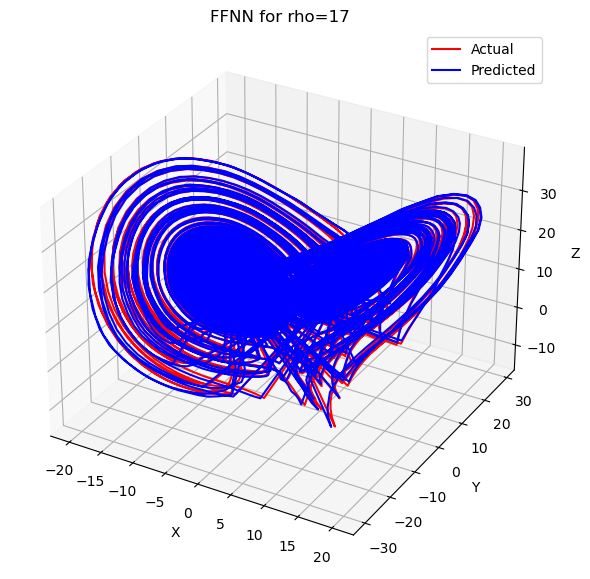

2500/2500 [==============================] - 2s 702us/step
FFNN Mean Squared Error on data with rho=35: 0.018447263532540736


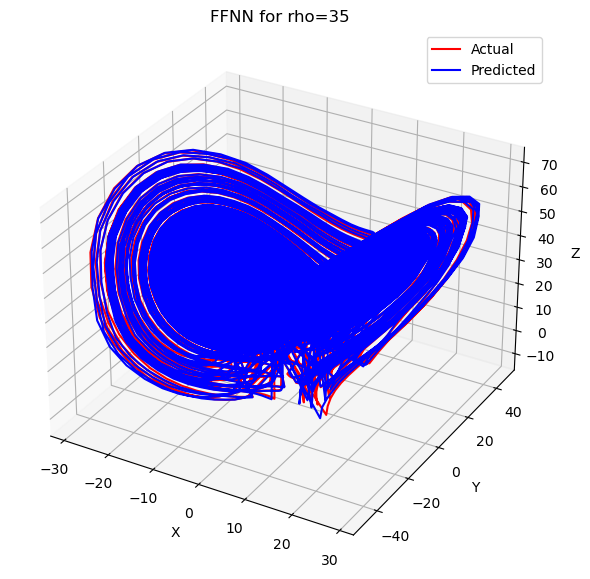

In [69]:
# Generate new data for rho=17
rho_17 = 17
inputs_17, targets_17 = generate_data(rho_17)

# Use the trained model to make predictions for the new data
predictions_17 = ffnn.predict(inputs_17)

mse_17 = mean_squared_error(targets_17, predictions_17)
print(f'FFNN Mean Squared Error on data with rho={rho_17}: {mse_17}')

plot_predictions(targets_17, predictions_17, f'FFNN for rho={rho_17}')

# Generate new data for rho=35
rho_35 = 35
inputs_35, targets_35 = generate_data(rho_35)

# Use the trained model to make predictions for the new data
predictions_35 = ffnn.predict(inputs_35)

mse_35 = mean_squared_error(targets_35, predictions_35)
print(f'FFNN Mean Squared Error on data with rho={rho_35}: {mse_35}')

plot_predictions(targets_35, predictions_35, f'FFNN for rho={rho_35}')

### Predicting with LSTM

2500/2500 [==============================] - 2s 923us/step
LSTM Mean Squared Error on data with rho=17: 0.007857595820124783


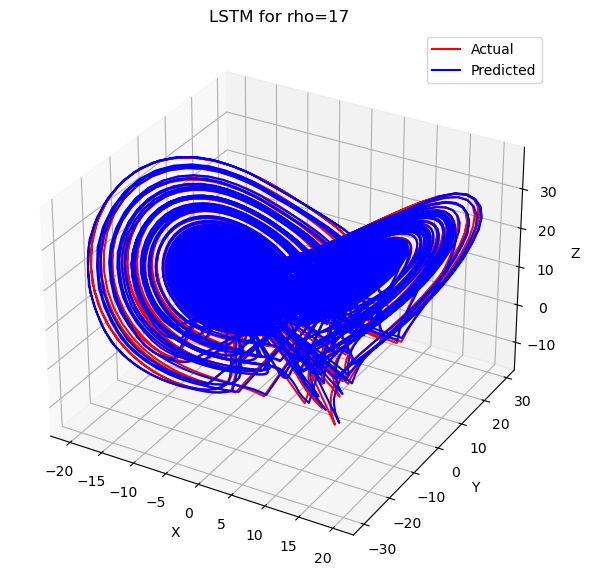

2500/2500 [==============================] - 2s 854us/step
LSTM Mean Squared Error on data with rho=35: 0.01220846529891217


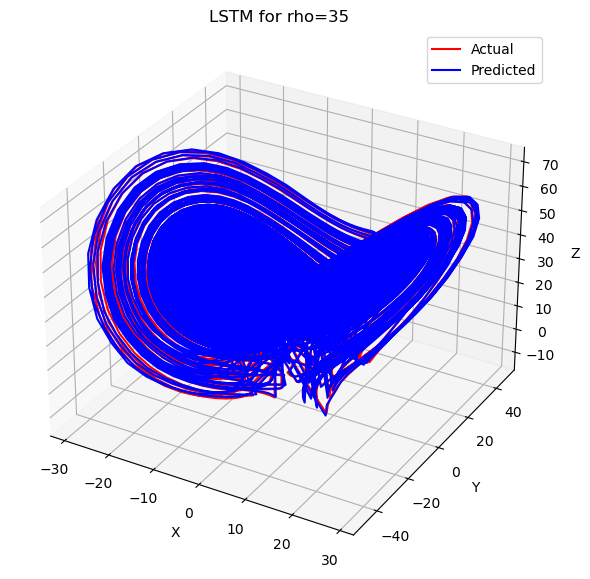

In [70]:
# Generate new data for rho=17
rho_17 = 17
inputs_17, targets_17 = generate_data(rho_17)

# Reshape new_inputs for LSTM [samples, time steps, features]
inputs_17 = inputs_17.reshape((inputs_17.shape[0], 1, inputs_17.shape[1]))

# Use the trained model to make predictions for the new data
predictions_17 = lstm.predict(inputs_17)

# Calculate and print the MSE
mse_17 = mean_squared_error(targets_17, predictions_17)
print(f'LSTM Mean Squared Error on data with rho={rho_17}: {mse_17}')

plot_predictions(targets_17, predictions_17, f'LSTM for rho={rho_17}')

# Generate new data for rho=35
rho_35 = 35
inputs_35, targets_35 = generate_data(rho_35)

# Reshape new_inputs for LSTM [samples, time steps, features]
inputs_35 = inputs_35.reshape((inputs_35.shape[0], 1, inputs_35.shape[1]))

# Use the trained model to make predictions for the new data
predictions_35 = lstm.predict(inputs_35)

# Calculate and print the MSE
mse_35 = mean_squared_error(targets_35, predictions_35)
print(f'LSTM Mean Squared Error on data with rho={rho_35}: {mse_35}')

plot_predictions(targets_35, predictions_35, f'LSTM for rho={rho_35}')

### Predicting with RNN

2500/2500 [==============================] - 2s 764us/step
RNN Mean Squared Error on new data with rho=17: 0.006687596111428704


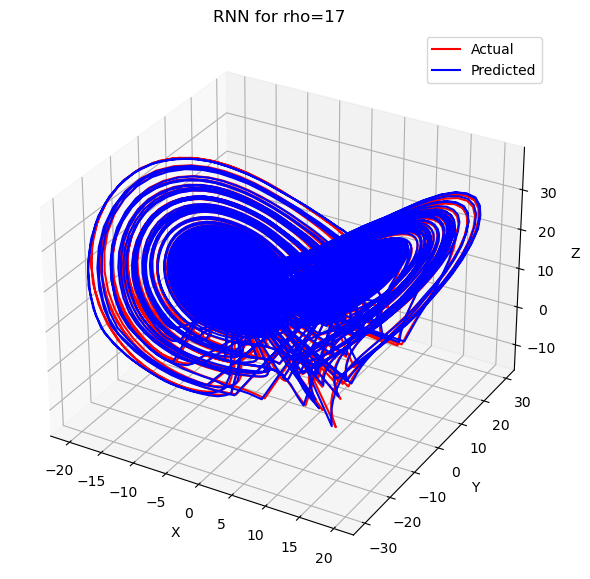

2500/2500 [==============================] - 2s 762us/step
RNN Mean Squared Error on new data with rho=35: 0.01453483413451468


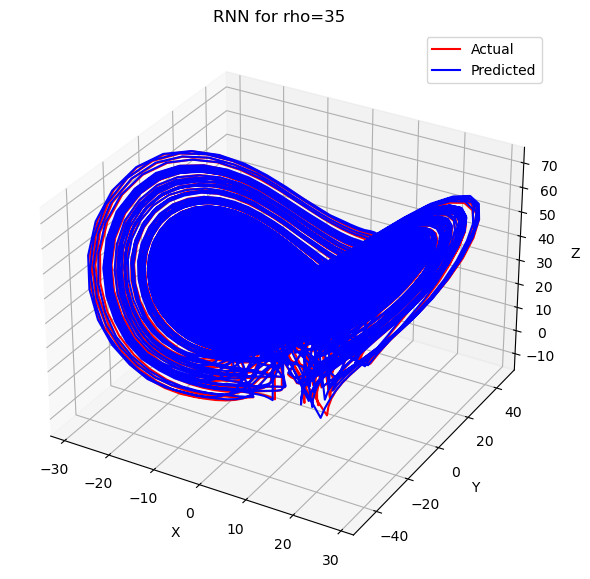

In [71]:
# Generate new data for rho=17
rho_17 = 17
inputs_17, targets_17 = generate_data(rho_17)

# Reshape new_inputs for RNN [samples, time steps, features]
inputs_17 = inputs_17.reshape((inputs_17.shape[0], 1, inputs_17.shape[1]))

# Use the trained model to make predictions for the new data
predictions_17 = rnn.predict(inputs_17)

# Calculate and print the MSE
mse_17 = mean_squared_error(targets_17, predictions_17)
print(f'RNN Mean Squared Error on new data with rho={rho_17}: {mse_17}')

plot_predictions(targets_17, predictions_17, f'RNN for rho={rho_17}')

# Generate new data for rho=35
rho_35 = 35
inputs_35, targets_35 = generate_data(rho_35)

# Reshape new_inputs for RNN [samples, time steps, features]
inputs_35 = inputs_35.reshape((inputs_35.shape[0], 1, inputs_35.shape[1]))

# Use the trained model to make predictions for the new data
predictions_35 = rnn.predict(inputs_35)

# Calculate and print the MSE
mse_35 = mean_squared_error(targets_35, predictions_35)
print(f'RNN Mean Squared Error on new data with rho={rho_35}: {mse_35}')

plot_predictions(targets_35, predictions_35, f'RNN for rho={rho_35}')

### Predicting with ESN

2500/2500 [==============================] - 2s 808us/step
ESN Mean Squared Error on new data with rho=17: 7.3480197726095335


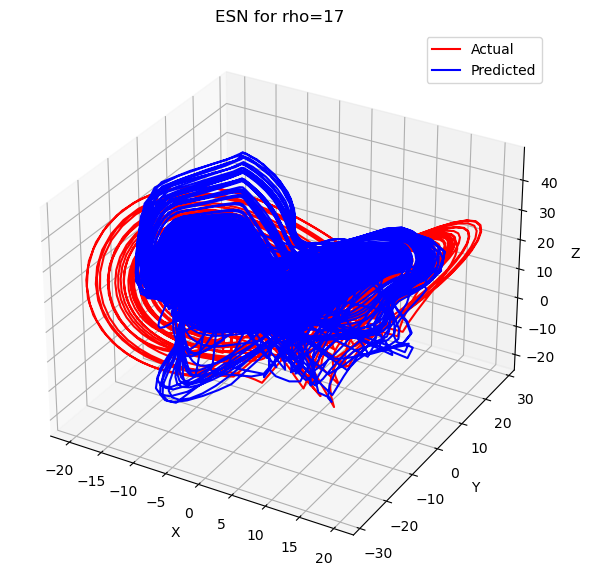

2500/2500 [==============================] - 2s 771us/step
ESN Mean Squared Error on new data with rho=35: 9.36647415049897


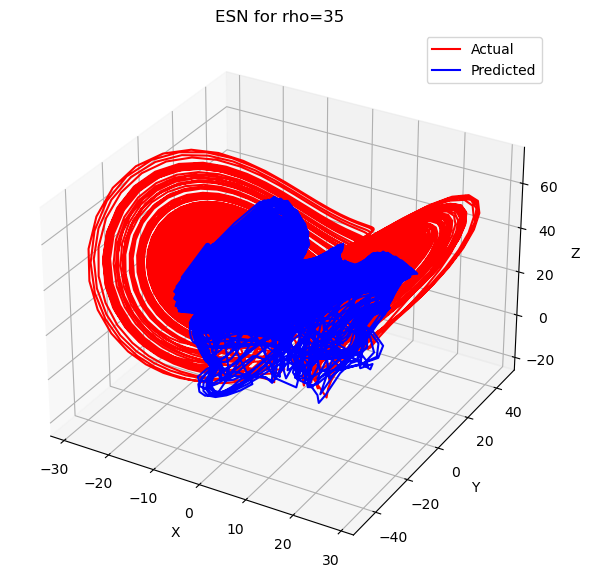

In [72]:
# Generate new data for rho=17
rho_17 = 17
inputs_17, targets_17 = generate_data(rho_17)

# Reshape new_inputs for ESN [samples, time steps, features]
inputs_17 = inputs_17.reshape((inputs_17.shape[0], 1, inputs_17.shape[1]))

# Use the trained model to make predictions for the new data
predictions_17 = esn_model.predict(inputs_17)

# Calculate and print the MSE
mse_17 = mean_squared_error(targets_17, predictions_17)
print(f'ESN Mean Squared Error on new data with rho={rho_17}: {mse_17}')

plot_predictions(targets_17, predictions_17, f'ESN for rho={rho_17}')

# Generate new data for rho=35
rho_35 = 35
inputs_35, targets_35 = generate_data(rho_35)

# Reshape new_inputs for ESN [samples, time steps, features]
inputs_35 = inputs_35.reshape((inputs_35.shape[0], 1, inputs_35.shape[1]))

# Use the trained model to make predictions for the new data
predictions_35 = esn_model.predict(inputs_35)

# Calculate and print the MSE
mse_35 = mean_squared_error(targets_35, predictions_35)
print(f'ESN Mean Squared Error on new data with rho={rho_35}: {mse_35}')

plot_predictions(targets_35, predictions_35, f'ESN for rho={rho_35}')